In [1]:
import psycopg2 as psql
import pandas as pd
import numpy as np
import pandas.io.sql as sqlio
from plotnine import *
import matplotlib.pyplot as plt

# Connect to and Query the Database

In [2]:
try:
    conn = psql.connect("dbname=swhgd-popular-3k-python user=postgres password=postgres")
except psql.Error as e:
    print(type(e))
    print(e)

![](dataset-schema.png)

In [3]:
query = """SELECT DISTINCT ON (o.url) o.url as url, 
CASE WHEN '2017-11-01'::DATE <= rev.date THEN 1 ELSE 0 END AS status,
o.type AS host_type,
CASE WHEN COUNT(rel.date) >= 1 THEN 1 ELSE 0 END AS major_releases
FROM revision rev 
FULL JOIN release rel on rev.id = rel.target
FULL JOIN snapshot_branch s_b ON rev.id = s_b.target 
FULL JOIN snapshot_branches s_bs ON s_bs.branch_id = s_b.object_id
FULL JOIN snapshot s ON s.object_id = s_bs.snapshot_id
FULL JOIN origin_visit ov ON ov.snapshot_id = s.object_id
FULL JOIN origin o on o.id = ov.origin
WHERE (rev.date >= '2005-05-09'::DATE AND rev.date <= '2018-01-01'::DATE)
GROUP BY o.url, rev.date, o.type;"""
data = sqlio.read_sql_query(query, conn)
data

,url,status,host_type,major_releases
0,deb://Debian/packages/accerciser,0,deb,0
1,deb://Debian/packages/agtl,0,deb,0
2,deb://Debian/packages/ajaxterm,0,deb,0
3,deb://Debian/packages/alacarte,0,deb,0
4,deb://Debian/packages/angrydd,0,deb,0
...,...,...,...,...
2081,https://pypi.org/project/zc.lockfile/,0,pypi,0
2082,https://pypi.org/project/zope.component/,0,pypi,0
2083,https://pypi.org/project/zope.deprecation/,0,pypi,0
2084,https://pypi.org/project/zope.interface/,0,pypi,0


In [4]:
query = """
SELECT o.url, COUNT(DISTINCT rev.author) as author_count
FROM revision rev 
FULL JOIN release rel on rev.id = rel.target
FULL JOIN snapshot_branch s_b ON rev.id = s_b.target 
FULL JOIN snapshot_branches s_bs ON s_bs.branch_id = s_b.object_id
FULL JOIN snapshot s ON s.object_id = s_bs.snapshot_id
FULL JOIN origin_visit ov ON ov.snapshot_id = s.object_id
FULL JOIN origin o on o.id = ov.origin
WHERE (rev.date >= '2005-05-09'::DATE AND rev.date <= '2018-01-01'::DATE)
GROUP BY o.url;
"""
author_count = sqlio.read_sql_query(query, conn)
author_count

,url,author_count
0,deb://Debian/packages/accerciser,4
1,deb://Debian/packages/agtl,2
2,deb://Debian/packages/ajaxterm,2
3,deb://Debian/packages/alacarte,3
4,deb://Debian/packages/angrydd,3
...,...,...
2081,https://pypi.org/project/zc.lockfile/,2
2082,https://pypi.org/project/zope.component/,3
2083,https://pypi.org/project/zope.deprecation/,2
2084,https://pypi.org/project/zope.interface/,3


In [5]:
query = """SELECT DISTINCT ON (o.url) o.url as url, min(r.date) OVER (PARTITION BY o.url) as min_date
FROM revision r join snapshot_branch s_b ON r.id = s_b.target 
FULL JOIN snapshot_branches s_bs ON s_bs.branch_id = s_b.object_id
FULL JOIN snapshot s ON s.object_id = s_bs.snapshot_id
FULL JOIN origin_visit ov ON ov.snapshot_id = s.object_id
FULL JOIN origin o on o.id = ov.origin
WHERE (r.date >= '2005-05-09'::DATE AND r.date <= '2018-01-01'::DATE);"""
min_dates = sqlio.read_sql_query(query, conn)
min_dates

,url,min_date
0,deb://Debian/packages/accerciser,2012-04-18 10:06:21-07:00
1,deb://Debian/packages/agtl,2011-01-22 04:55:12-08:00
2,deb://Debian/packages/ajaxterm,2011-08-19 07:31:06-07:00
3,deb://Debian/packages/alacarte,2012-06-29 03:43:50-07:00
4,deb://Debian/packages/angrydd,2008-10-19 05:19:40-07:00
...,...,...
2080,https://pypi.org/project/youtube_dl/,2013-01-19 16:34:50-08:00
2081,https://pypi.org/project/zc.lockfile/,2007-07-18 04:27:21-07:00
2082,https://pypi.org/project/zope.component/,2007-02-19 06:16:09-08:00
2083,https://pypi.org/project/zope.deprecation/,2007-02-18 13:55:54-08:00


In [6]:
query = """SELECT DISTINCT ON (o.url) o.url as url, max(r.date) OVER (PARTITION BY o.url) as max_date
FROM revision r join snapshot_branch s_b ON r.id = s_b.target 
FULL JOIN snapshot_branches s_bs ON s_bs.branch_id = s_b.object_id
FULL JOIN snapshot s ON s.object_id = s_bs.snapshot_id
FULL JOIN origin_visit ov ON ov.snapshot_id = s.object_id
FULL JOIN origin o on o.id = ov.origin
WHERE (r.date >= '2005-05-09'::DATE AND r.date <= '2018-01-01'::DATE);"""
max_dates = sqlio.read_sql_query(query, conn)
max_dates

,url,max_date
0,deb://Debian/packages/accerciser,2017-12-13 05:26:58-08:00
1,deb://Debian/packages/agtl,2015-08-19 13:36:54-07:00
2,deb://Debian/packages/ajaxterm,2015-05-31 10:43:09-07:00
3,deb://Debian/packages/alacarte,2017-12-18 18:44:02-08:00
4,deb://Debian/packages/angrydd,2016-04-24 12:35:20-07:00
...,...,...
2080,https://pypi.org/project/youtube_dl/,2017-12-30 13:32:44-08:00
2081,https://pypi.org/project/zc.lockfile/,2016-06-19 09:27:26-07:00
2082,https://pypi.org/project/zope.component/,2017-09-26 04:17:58-07:00
2083,https://pypi.org/project/zope.deprecation/,2017-08-07 12:24:01-07:00


In [7]:
query = """SELECT o.url as url,
COUNT(rev.date) as rev_count
FROM revision rev 
FULL JOIN release rel on rev.id = rel.target
FULL JOIN snapshot_branch s_b ON rev.id = s_b.target 
FULL JOIN snapshot_branches s_bs ON s_bs.branch_id = s_b.object_id
FULL JOIN snapshot s ON s.object_id = s_bs.snapshot_id
FULL JOIN origin_visit ov ON ov.snapshot_id = s.object_id
FULL JOIN origin o on o.id = ov.origin
WHERE (rev.date >= '2005-05-09'::DATE AND rev.date <= '2018-01-01'::DATE)
GROUP BY o.url"""
rev_counts = sqlio.read_sql_query(query, conn)
rev_counts

,url,rev_count
0,deb://Debian/packages/accerciser,1192
1,deb://Debian/packages/agtl,1147
2,deb://Debian/packages/ajaxterm,1248
3,deb://Debian/packages/alacarte,1242
4,deb://Debian/packages/angrydd,1254
...,...,...
2081,https://pypi.org/project/zc.lockfile/,7
2082,https://pypi.org/project/zope.component/,31
2083,https://pypi.org/project/zope.deprecation/,13
2084,https://pypi.org/project/zope.interface/,41


## Calculate the Duration in Months (28 days) for each Project

In [8]:
durations = pd.merge(left=max_dates, right=min_dates, left_on='url', right_on='url')
durations['duration'] = (((durations['max_date'] - durations['min_date'])/np.timedelta64(1,'D'))/28).astype(int) #convert timedelta in days to int that represents months
durations = durations.drop(columns=['max_date', 'min_date'])
durations

,url,duration
0,deb://Debian/packages/accerciser,73
1,deb://Debian/packages/agtl,59
2,deb://Debian/packages/ajaxterm,49
3,deb://Debian/packages/alacarte,71
4,deb://Debian/packages/angrydd,98
...,...,...
2080,https://pypi.org/project/youtube_dl/,64
2081,https://pypi.org/project/zc.lockfile/,116
2082,https://pypi.org/project/zope.component/,138
2083,https://pypi.org/project/zope.deprecation/,136


## Merge all our dataframes together

In [9]:
data = data.merge(durations, on='url')
data = data.merge(author_count, on='url')
data = data.merge(rev_counts, on='url')

## Remove projects with only one revision

In [10]:
data = data.query('rev_count > 1')

In [11]:
data

,url,status,host_type,major_releases,duration,author_count,rev_count
0,deb://Debian/packages/accerciser,0,deb,0,73,4,1192
1,deb://Debian/packages/agtl,0,deb,0,59,2,1147
2,deb://Debian/packages/ajaxterm,0,deb,0,49,2,1248
3,deb://Debian/packages/alacarte,0,deb,0,71,3,1242
4,deb://Debian/packages/angrydd,0,deb,0,98,3,1254
...,...,...,...,...,...,...,...
2080,https://pypi.org/project/youtube_dl/,0,pypi,0,64,2,794
2081,https://pypi.org/project/zc.lockfile/,0,pypi,0,116,2,7
2082,https://pypi.org/project/zope.component/,0,pypi,0,138,3,31
2083,https://pypi.org/project/zope.deprecation/,0,pypi,0,136,2,13


## Extract Project Names from URLs

In [12]:
projects = []
for elem in data['url'].str.findall("(.+)/(.+)(/*$)"):
    projects.append(elem[0][1].replace("/",""))
data['project'] = projects
data


,url,status,host_type,major_releases,duration,author_count,rev_count,project
0,deb://Debian/packages/accerciser,0,deb,0,73,4,1192,accerciser
1,deb://Debian/packages/agtl,0,deb,0,59,2,1147,agtl
2,deb://Debian/packages/ajaxterm,0,deb,0,49,2,1248,ajaxterm
3,deb://Debian/packages/alacarte,0,deb,0,71,3,1242,alacarte
4,deb://Debian/packages/angrydd,0,deb,0,98,3,1254,angrydd
...,...,...,...,...,...,...,...,...
2080,https://pypi.org/project/youtube_dl/,0,pypi,0,64,2,794,youtube_dl
2081,https://pypi.org/project/zc.lockfile/,0,pypi,0,116,2,7,zc.lockfile
2082,https://pypi.org/project/zope.component/,0,pypi,0,138,3,31,zope.component
2083,https://pypi.org/project/zope.deprecation/,0,pypi,0,136,2,13,zope.deprecation


In [13]:
data['url'] = data['url'].astype(str)
data['host_type'] = data['host_type'].astype(str)
data['project'] = data['project'].astype(str)

## Determine Whether Projects are Hosted on Multiple Repositories

In [14]:
# These are mistakes the project and host_type should uniquely identify the repos, but git projects
# can have duplicated names, so these projects are not actually hosted on multiple repos
temp = data.groupby(['project', 'host_type']).count()['status']
non_multi_repo_projects = [x for (x,y) in temp[temp > 1].index]
non_multi_repo_projects


['Python', 'algorithms', 'dataset', 'models', 'seq2seq', 'sshuttle', 'tqdm']

In [15]:
temp = data.groupby(['project']).count()['status']
temp[temp == 1] = 0
temp[temp > 1] = 1
# fix errors
temp[non_multi_repo_projects] = 0

multi_repo = []
for i, row in data.iterrows():
    multi_repo.append(temp[row['project']])

data['multi_repo'] = multi_repo
data[data['multi_repo'] == 1]


,url,status,host_type,major_releases,duration,author_count,rev_count,project,multi_repo
6,deb://Debian/packages/ansible,0,deb,0,41,3,1185,ansible,1
18,deb://Debian/packages/asciinema,0,deb,0,49,1,805,asciinema,1
21,deb://Debian/packages/autojump,0,deb,0,58,1,1178,autojump,1
27,deb://Debian/packages/beets,0,deb,0,68,4,928,beets,1
44,deb://Debian/packages/buildbot,0,deb,0,73,3,978,buildbot,1
...,...,...,...,...,...,...,...,...,...
2058,https://pypi.org/project/troposphere/,0,pypi,0,62,1,42,troposphere,1
2065,https://pypi.org/project/uvloop/,0,pypi,0,21,2,52,uvloop,1
2068,https://pypi.org/project/virtualenv/,0,pypi,0,119,2,84,virtualenv,1
2071,https://pypi.org/project/watchdog/,0,pypi,0,52,2,12,watchdog,1


## Create Commit Frequency Field

In [16]:
# Need to extract # of commits during time frame, then divide by duration

## Save to a CSV file

In [17]:
data.to_csv('data.csv')

# Create Figure 1 (Ordered Timeline of Projects)

In [18]:
beginning_month = pd.to_datetime('2005-01-01 00:00:00-07:00', utc=True)
ending_month = pd.to_datetime('2018-01-01 00:00:00-07:00', utc=True)
graph_data = pd.read_csv('max-min-dates.csv')
graph_data['max_date']= pd.to_datetime(graph_data['max_date'], utc=True)
graph_data['min_date']= pd.to_datetime(graph_data['min_date'], utc=True)
graph_data['duration'] = (((graph_data['max_date'] - graph_data['min_date'])/np.timedelta64(1,'D'))/28).astype(int)
graph_data['start_month'] = (((graph_data['min_date'] - beginning_month)/np.timedelta64(1,'D'))/28).astype(int)
graph_data['end_month'] = (((graph_data['max_date'] - beginning_month)/np.timedelta64(1,'D'))/28).astype(int)
graph_data = graph_data.sort_values(by=['duration'])
graph_data

,Unnamed: 0,url,max_date,min_date,duration,start_month,end_month
292,292,deb://Debian/packages/ndisgtk,2010-01-28 16:21:50+00:00,2010-01-28 16:21:50+00:00,0,66,66
177,177,deb://Debian/packages/gnome-mousetrap,2016-09-04 16:48:33+00:00,2016-09-04 16:48:33+00:00,0,152,152
402,402,deb://Debian/packages/python-cligj,2015-12-25 15:12:25+00:00,2015-12-25 15:12:25+00:00,0,143,143
1825,1825,https://pypi.org/project/crcmod/,2010-06-27 14:35:29+00:00,2010-06-27 14:35:29+00:00,0,71,71
546,546,deb://Debian/packages/python-os-collect-config,2014-04-14 15:44:47+00:00,2014-04-14 15:44:47+00:00,0,121,121
...,...,...,...,...,...,...,...
1251,1251,https://github.com/fail2ban/fail2ban,2017-12-22 13:12:19+00:00,2005-02-24 13:59:34+00:00,167,1,169
1513,1513,https://github.com/python/cpython,2017-12-31 22:34:57+00:00,2005-01-26 04:55:57+00:00,168,0,169
1549,1549,https://github.com/scipy/scipy,2017-12-29 03:58:05+00:00,2005-01-06 18:19:33+00:00,169,0,169
1555,1555,https://github.com/secdev/scapy,2017-12-30 17:46:06+00:00,2005-01-10 20:55:14+00:00,169,0,169


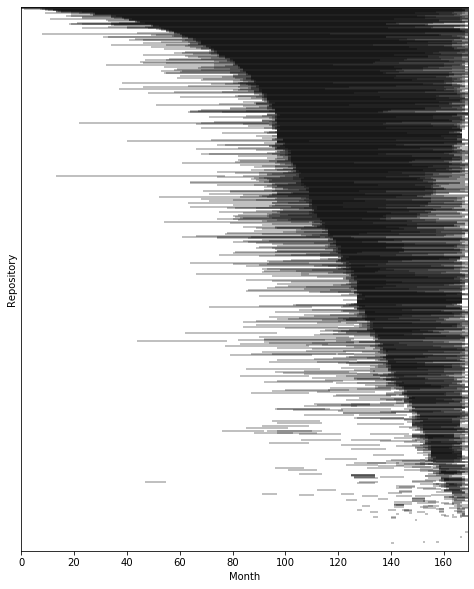

In [19]:
plt.rcParams["figure.figsize"]=[8,10]
plt.hlines(y=np.arange(graph_data.shape[0]), xmin=graph_data['start_month'], xmax=graph_data['end_month'], colors='black', linewidth=0.49)
plt.tick_params(left=False, labelleft=False)
plt.ylabel('Repository')
plt.xlabel('Month')
plt.xlim((0, int((((ending_month - beginning_month)/np.timedelta64(1,'D'))/28))))
plt.ylim((0, graph_data.shape[0]))
plt.savefig('figure1.jpg',bbox_inches='tight', dpi=150)